### Instalando librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
import keras

from keras.models import Sequential
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
tf.__version__

'2.2.0'

### Lectura de datos csv

In [6]:
train_df=pd.read_csv('../data/mitbih_train.csv',header=None)
test_df=pd.read_csv('../data/mitbih_test.csv',header=None)

### Preprocesamiento

In [7]:
from sklearn.utils import resample

df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

### Agregando ruido
---
Esto sirve para generalizar mejor el modelo

In [8]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

In [9]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

NameError: name 'c' is not defined

### Shaping

In [ ]:
target_train = train_df[187]
target_test = test_df[187]

y_train = to_categorical(target_train)
y_test = to_categorical(target_test)

In [ ]:
len(y_test)

In [ ]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

print('Antes del reshaping: ', X_train.shape)

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

print('Despues del reshapin: ', X_train.shape)

### Modelo

In [21]:
model = Sequential()

model.add(Convolution1D(32, (6), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(3), strides=(2), padding="same"))

model.add(Convolution1D(32, (3), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(2), strides=(2), padding="same"))

model.add(Convolution1D(32, (3), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(2), strides=(2), padding="same"))

model.add(Flatten())

model.add(Dense(5, activation='softmax', name='main_output'))

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='conv_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=256,validation_data=(X_test,y_test))

Epoch 1/40
391/391 [==============================] - 48s 124ms/step - loss: 0.3487 - accuracy: 0.8754 - val_loss: 1.9996 - val_accuracy: 0.1516
Epoch 2/40
391/391 [==============================] - 51s 131ms/step - loss: 0.1577 - accuracy: 0.9468 - val_loss: 0.2437 - val_accuracy: 0.9165
Epoch 3/40
391/391 [==============================] - 52s 133ms/step - loss: 0.1136 - accuracy: 0.9630 - val_loss: 0.1683 - val_accuracy: 0.9442
Epoch 4/40
391/391 [==============================] - 51s 131ms/step - loss: 0.0925 - accuracy: 0.9702 - val_loss: 0.1858 - val_accuracy: 0.9383
Epoch 5/40
391/391 [==============================] - 55s 140ms/step - loss: 0.0765 - accuracy: 0.9748 - val_loss: 0.1509 - val_accuracy: 0.9530
Epoch 6/40
391/391 [==============================] - 55s 141ms/step - loss: 0.0654 - accuracy: 0.9789 - val_loss: 0.1485 - val_accuracy: 0.9551
Epoch 7/40
391/391 [==============================] - 52s 132ms/step - loss: 0.0575 - accuracy: 0.9812 - val_loss: 0.1354 - val_ac

### Ploting results

In [22]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

Accuracy: 96.12%


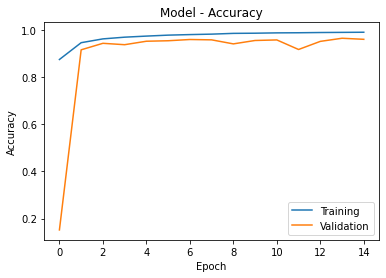

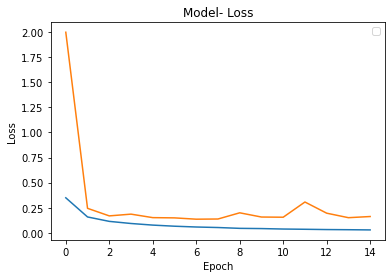

In [23]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [11]:
model_name = 'best_model.h5'
model = keras.models.load_model(f'../model/{model_name}')

# y_pred = model.predict(X_test)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      [(None, 186, 1)]          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 181, 64)           448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 181, 64)           256       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 91, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 89, 64)            12352     
_________________________________________________________________
batch_normalization_7 (Batch (None, 89, 64)            256       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 45, 64)            0   

### Confusion matrix

Normalized confusion matrix


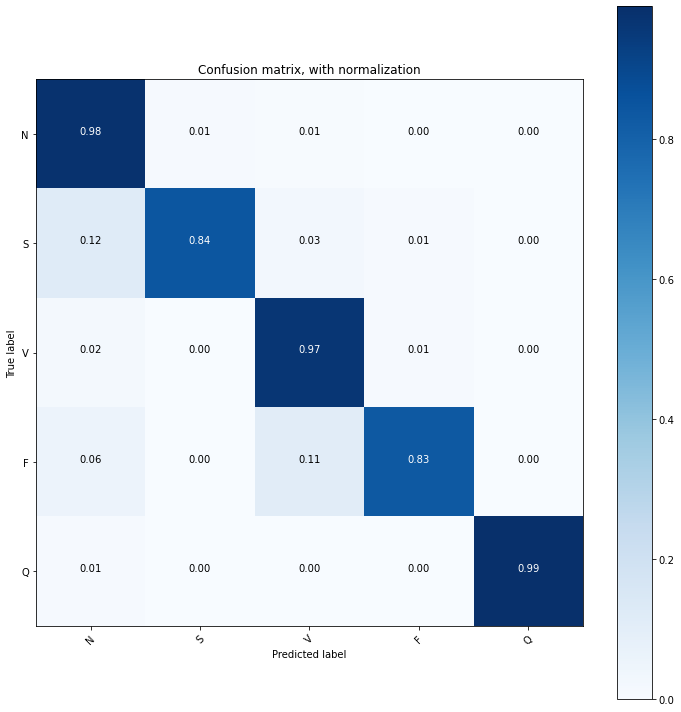

In [35]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()